# Plot the nose tip

In [4]:
import os
import numpy as np
from one.api import ONE
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
#from video_functions import get_raw_and_smooth_pupil_dia, SNR, get_dlc_XYs_pupil
from one_functions_generic import subjects_interest_data, prepro

In [21]:

import numpy as np
from one.api import ONE
from scipy.interpolate import interp1d
one = ONE() 

""" PUPIL """

def get_dlc_XYs_pupil(one, eid, view, likelihood_thresh=0.9):
    dataset_types = ['camera.dlc', 'camera.times']
    try:
        times = one.load_dataset(eid, '_ibl_%sCamera.times.npy' % view)
        cam = one.load_dataset(eid, '_ibl_%sCamera.dlc.pqt' % view)
    except KeyError:
        print('not all dlc data available')
        return None, None
    points = np.unique(['_'.join(x.split('_')[:-1]) for x in cam.keys()])
    # Set values to nan if likelyhood is too low # for pqt: .to_numpy()
    XYs = {}
    for point in points:
        x = np.ma.masked_where(cam[point + '_likelihood'] < likelihood_thresh, cam[point + '_x'])
        x = x.filled(np.nan)
        y = np.ma.masked_where(cam[point + '_likelihood'] < likelihood_thresh, cam[point + '_y'])
        y = y.filled(np.nan)
        XYs[point] = np.array([x, y]).T
    return times, XYs


def smooth_interpolate_signal_sg(signal, window=31, order=3, interp_kind='cubic'):
    """Run savitzy-golay filter on signal, interpolate through nan points.
    
    Parameters
    ----------
    signal : np.ndarray
        original noisy signal of shape (t,), may contain nans
    window : int
        window of polynomial fit for savitzy-golay filter
    order : int
        order of polynomial for savitzy-golay filter
    interp_kind : str
        type of interpolation for nans, e.g. 'linear', 'quadratic', 'cubic'

    Returns
    -------
    np.array
        smoothed, interpolated signal for each time point, shape (t,)
        
    """

    signal_noisy_w_nans = np.copy(signal)
    timestamps = np.arange(signal_noisy_w_nans.shape[0])
    good_idxs = np.where(~np.isnan(signal_noisy_w_nans))[0]
    # perform savitzky-golay filtering on non-nan points
    signal_smooth_nonans = non_uniform_savgol(
        timestamps[good_idxs], signal_noisy_w_nans[good_idxs], window=window, polynom=order)
    signal_smooth_w_nans = np.copy(signal_noisy_w_nans)
    signal_smooth_w_nans[good_idxs] = signal_smooth_nonans
    # interpolate nan points
    interpolater = interp1d(
        timestamps[good_idxs], signal_smooth_nonans, kind=interp_kind, fill_value='extrapolate')

    signal = interpolater(timestamps)

    return signal


def non_uniform_savgol(x, y, window, polynom):
    """Applies a Savitzky-Golay filter to y with non-uniform spacing as defined in x.

    This is based on 
    https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    https://dsp.stackexchange.com/a/64313

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array
        The smoothed y values
    """

    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))  # Matrix
    tA = np.empty((polynom, window))  # Transposed matrix
    t = np.empty(window)  # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed



def get_pupil_diameter(XYs):
    """Estimate pupil diameter by taking median of different computations.
    
    In the two most obvious ways:
    d1 = top - bottom, d2 = left - right
    
    In addition, assume the pupil is a circle and estimate diameter from other pairs of 
    points
    
    Author: Michael Schartner
    
    Parameters
    ----------
    XYs : dict
        keys should include `pupil_top_r`, `pupil_bottom_r`, 
        `pupil_left_r`, `pupil_right_r`

    Returns
    -------
    np.array
        pupil diameter estimate for each time point, shape (n_frames,)
    
    """
    
    # direct diameters
    t = XYs['pupil_top_r'][:, :2]
    b = XYs['pupil_bottom_r'][:, :2]
    l = XYs['pupil_left_r'][:, :2]
    r = XYs['pupil_right_r'][:, :2]

    def distance(p1, p2):
        return ((p1[:, 0] - p2[:, 0]) ** 2 + (p1[:, 1] - p2[:, 1]) ** 2) ** 0.5

    # get diameter via top-bottom and left-right
    ds = []
    ds.append(distance(t, b))
    ds.append(distance(l, r))

    def dia_via_circle(p1, p2):
        # only valid for non-crossing edges
        u = distance(p1, p2)
        return u * (2 ** 0.5)

    # estimate diameter via circle assumption
    for side in [[t, l], [t, r], [b, l], [b, r]]:
        ds.append(dia_via_circle(side[0], side[1]))
    diam = np.nanmedian(ds, axis=0)


    return diam


def get_raw_and_smooth_pupil_dia(eid, video_type):

    # likelihood threshold
    l_thresh = 0.9

    # camera view
    view = video_type

    # threshold (in standard deviations) beyond which a point is labeled as an outlier
    std_thresh = 5

    # threshold (in seconds) above which we will not interpolate nans, but keep them
    # (for long stretches interpolation may not be appropriate)
    nan_thresh = 1

    # compute framerate of camera
    if view == 'left':
        fr = 60  # set by hardware
        window = 31  # works well empirically
    elif view == 'right':
        fr = 150  # set by hardware
        window = 75  # works well empirically
    else:
        raise NotImplementedError

    # load markers
    _, markers = get_dlc_XYs_pupil(one, eid, view, likelihood_thresh=l_thresh)

    # compute diameter using raw values of 4 markers (will be noisy and have missing data)
    X_center0, Y_center = nose_tip(markers)

    # run savitzy-golay filter on non-nan timepoints to denoise
    X_center_sm0 = smooth_interpolate_signal_sg(
        X_center0, window=window, order=3, interp_kind='linear')

    # find outliers, set to nan
    errors = X_center0 - X_center_sm0
    std = np.nanstd(errors)
    X_center1 = np.copy(X_center0)
    X_center1[(errors < (-std_thresh * std)) | (errors > (std_thresh * std))] = np.nan
    # run savitzy-golay filter again on (possibly reduced) non-nan timepoints to denoise
    X_center_sm1 = smooth_interpolate_signal_sg(
        X_center1, window=window, order=3, interp_kind='linear')

    # don't interpolate long strings of nans
    t = np.diff(1 * np.isnan(X_center1))
    begs = np.where(t == 1)[0]
    ends = np.where(t == -1)[0]
    if begs.shape[0] > ends.shape[0]:
        begs = begs[:ends.shape[0]]
    for b, e in zip(begs, ends):
        if (e - b) > (fr * nan_thresh):
            X_center_sm1[(b + 1):(e + 1)] = np.nan  # offset by 1 due to earlier diff
            
    # diam_sm1 is the final smoothed pupil diameter estimate
    return X_center0, X_center_sm1

def nose_tip(XYs):


    X = XYs['nose_tip'][:, 0]
    Y = XYs['nose_tip'][:, 1]

    return Y, X

In [22]:
one = ONE()    
eid = '572a95d1-39ca-42e1-8424-5c9ffcb2df87'
video_type = 'left'

pupil_dia_raw_left, pupil_dia_smooth_left = (
    get_raw_and_smooth_pupil_dia(eid, video_type))
times, XYs = get_dlc_XYs_pupil(one, eid, view='left', likelihood_thresh=0.9)


In [7]:
trials_mouse = one.load_object(eid, obj='trials', namespace='ibl')
trials_df = trials_mouse.to_df()

local md5 mismatch on dataset: cortexlab/Subjects/KS020/2020-02-07/001/alf/_ibl_trials.goCueTrigger_times.npy
/opt/anaconda3/envs/iblenv/lib/python3.9/site-packages/one/webclient.py:127: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS020/2020-02-07/001/alf/_ibl_trials.goCueTrigger_times.304738a6-9753-4607-8110-d9e3fa2adfde.npy Bytes: 2840


100%|██████████| 0.00270843505859375/0.00270843505859375 [00:00<00:00,  1.26s/it]


In [8]:
processed_trials = prepro(trials_df)

In [27]:
event = 'stimOn_times'
event = 'feedback_times'
t_init = 0.5
t_end = 2
interval_length = 2500

In [28]:
# Function parameters
position = pupil_dia_smooth_left
time = times[0:len(position)]
trials = trials_df

# Initialize dataframe
df = pd.DataFrame({'time':time, 'position':position})

onset_times = trials[event]

# Calculate max and min of the session for normalization
max_pupil = np.max(df['position'])
min_pupil = np.min(df['position'])

# Normalize pupil size
df['norm_position'] = (df['position'] - min_pupil) * 100 / (max_pupil - min_pupil)

# Start a matrix with #trials x # enough entries for the interval # TODO: need to fix interval length
stack = np.zeros((len(onset_times), interval_length)) * np.nan

for t, trial_onset in enumerate(onset_times):
    if np.isnan(trial_onset) == False:
        if len(df.loc[df['time'] > trial_onset-t_init, 'time']) > 0:

            # Calculate baseline (always in relation to StimOnTime)
            stim_on = trials['stimOn_times'][t]
            baseline = np.mean(df.loc[(df['time'] > stim_on-0.5) & (df['time'] <= stim_on), 'norm_position'])

            # Populate dataframe with useful trial-aligned information
            temp_stack = df.loc[(df['time']> trial_onset-t_init) & (df['time'] <= trial_onset+t_end), 'norm_position'] - baseline
            stack[t, 0:len(temp_stack)] = temp_stack

In [29]:
pupil_stack = pd.DataFrame(stack)
pupil_stack['feedback'] = list(processed_trials['correct'])
pupil_stack['choice'] = list(processed_trials['choice'])
pupil_stack['contrast'] = list(processed_trials['contrast'])
pupil_stack['side'] = list(np.sign(processed_trials['signed_contrast']))

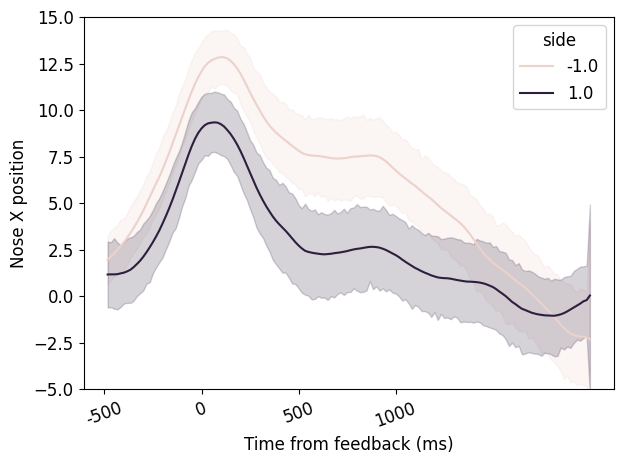

In [32]:
# TODO: need to fix time
import seaborn as sns
melted = pd.melt(pupil_stack, id_vars=['feedback', 'choice', 'contrast', 'side'], value_vars=np.array(pupil_stack.keys()[1:-4]))
correct_data = melted.loc[(melted['contrast']>0) & (melted['contrast']<=1) & (melted['feedback']==1)]
incorrect_data = melted.loc[(melted['contrast']>0) & (melted['contrast']<=1) & (melted['feedback']==0)]
use_data = melted.loc[(melted['contrast']>0) & (melted['contrast']<=.5)]
use_data = melted.loc[(melted['contrast']>0)]
plt.rc('font', size=12)

sns.lineplot(x='variable', y='value', hue='side', data=use_data)  #  style='feedback',
plt.xlabel('Time from feedback (ms)')
plt.ylabel('Nose X position')
plt.xticks([0, 30, 60, 90], [-500, 0, 500, 1000],
       rotation=20)
plt.ylim([-5, 15])
#plt.title('Proficient session')
plt.tight_layout()